## Семинар 10: "Генерация текстов"

ФИО: Ира Букреева

In [1]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
from tqdm.autonotebook import tqdm
import progressbar
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

In [2]:
!wget https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt

--2020-12-09 19:51:19--  https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5615127 (5.4M) [text/plain]
Saving to: ‘author-quote.txt.6’

author-quote.txt.6  100%[===================>]   5.35M  --.-KB/s    in 0.1s    

2020-12-09 19:51:20 (44.7 MB/s) - ‘author-quote.txt.6’ saved [5615127/5615127]



Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [3]:
lines = [
    re.sub(r'[.,:\;!#]', '', x.split('\t')[1].strip()).lower().split() ##!!!!!
    for x in open('author-quote.txt').readlines()
]

In [4]:
len(lines)

39269

In [5]:
# lines[:1]

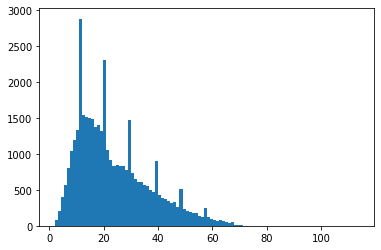

In [6]:
plt.hist(list(map(len, lines)), bins=100); #распределение длин фраз

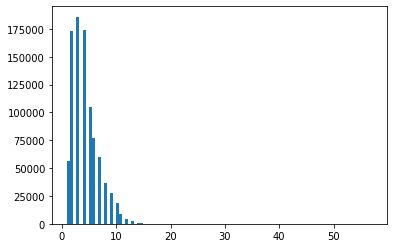

In [7]:
from itertools import chain
a = list(chain(*list(map(lambda x: [len(a) for a in x], lines))))
plt.hist(a, bins=100); #распределение длин слов

In [8]:
# lines = list(
#     filter(lambda x: len(x.split()) <= 50,
#            lines)
# )

In [9]:
np.random.seed(777)
torch.manual_seed(777)

In [10]:
class Vocabulary:
    def __init__(self, sentences):
        all_words = set()
        for line in sentences:
            all_words |= set(line)
        all_words = list(sorted(all_words))+['<eos>', '<go>']
        self.word_to_id = {
            x[1]:x[0]
            for x in enumerate(all_words)
        }
        self.id_to_word = {
            x[0]:x[1]
            for x in enumerate(all_words)
        }
        self.size = len(all_words)

    def encode(self, line):
        return [self.word_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ' '.join([self.id_to_word[x] for x in tokens])

In [11]:
vocab = Vocabulary(lines)

In [12]:
assert vocab.decode(vocab.encode(lines[0])) == ' '.join(lines[0])

In [13]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.word_to_id['<go>']
        self.eos = self.vocab.word_to_id['<eos>']

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [14]:
def compose_batch(batch):
    lengths = np.array([len(x[0]) for x in batch])
    order = np.argsort(-lengths)
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [15]:
dataset = Quotes(lines, vocab)

In [16]:
dataloader = DataLoader(
    dataset, shuffle=True,
    batch_size=64,
    collate_fn=compose_batch)

In [17]:
vocab.size

33277

### Часть 2: определение модели

In [18]:
#[sample_i, channels, w, h]

#[sample_i, w_i, emb_i] # batch_first=True
#[w_i, sample_i, emb_i] # batch_first=False

class Oracle(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2,
                 pretrained_emb=None):
        super().__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size

        if pretrained_emb is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_emb, freeze=False)
        else:
            self.embedding = nn.Embedding(vocabulary_size, embedding_size)        

        self.generator = nn.GRU(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=70):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line.split()) < max_len:
            token = torch.tensor([[vocab.word_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_word[new_token_id]
            line = line + " " + current_token
        return line

In [19]:
oracle = Oracle(vocab.size,
                embedding_size=50,
                hidden_size=64, layers=2)    

### Часть 3: обучение модели

In [20]:
optimizer = torch.optim.RMSprop(
    oracle.parameters(), lr=0.001, weight_decay=1e-5
)

In [21]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [22]:
losses = []

In [23]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [24]:
oracle.cuda()

Oracle(
  (embedding): Embedding(33277, 50)
  (generator): GRU(50, 64, num_layers=2)
  (classifier): Linear(in_features=64, out_features=33277, bias=True)
)

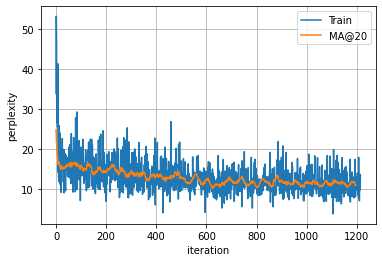

In [25]:
for epoch in range(2):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(
            tqdm(dataloader, total=len(dataloader))
    ):
        go = go.cuda()
        eos = eos.cuda()
        mask = mask.cuda()

        oracle.zero_grad()
        prediction = oracle(
            go, length
        ).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters() if x.grad is not None]
        optimizer.step()
        losses.append(np.exp(loss.cpu().item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

In [26]:
oracle.cpu()

Oracle(
  (embedding): Embedding(33277, 50)
  (generator): GRU(50, 64, num_layers=2)
  (classifier): Linear(in_features=64, out_features=33277, bias=True)
)

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

In [27]:
for _ in range(5):
  res = oracle.generate(vocab, max_len=700)
  print(res)

 every loser of the world is the guess is as i always like to will must play growth <eos>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 i'm more of event of football wife inherent in the other frets with my point on a natural message of intellectual recreate to yemen broker an one thing with poor that die people did conversation is me and fashion to 'golden very very the other and right roots and i like nothing you do pov and some day in your which naturally and beholding off <eos>
 success is a hundred of we think in only comedy armand the great government of any day away seize my favor <eos>
 what coming to fear it and acquire at an first thing that contributions <eos>
 from the mother that obama a viewing 8mm emitter of upward one matters <eos>


## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

#### 1. LSTMOracle

In [28]:
class LSTMOracle(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2,
                 pretrained_emb=None):
        super().__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size

        if pretrained_emb is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_emb, freeze=False)
        else:
            self.embedding = nn.Embedding(vocabulary_size, embedding_size)        

        self.generator = nn.LSTM(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=100):
        h = (torch.zeros(self.layers, 1, self.hidden_size),
             torch.zeros(self.layers, 1, self.hidden_size))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.word_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_word[new_token_id]
            line = line + " " + current_token
        return line

In [29]:
lstm_oracle = LSTMOracle(vocab.size,
                embedding_size=32,
                hidden_size=64, layers=2)    

optimizer = torch.optim.Adam(
    lstm_oracle.parameters(), lr=0.001, weight_decay=1e-5
)
criterion = nn.CrossEntropyLoss(reduction='none')

In [30]:
train_losses = []
test_losses = []

#### 2. Разбиение train/test, графики зависимости перплексии от числа эпох

In [31]:
train_size = int(len(lines) * 0.67)
test_size = len(lines) - train_size

train_dataset = Quotes(lines[:train_size], vocab)
test_dataset = Quotes(lines[train_size:], vocab)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)

In [32]:
# len(lines[:train_size]), len(lines[train_size:])
# lines[train_size:]

In [33]:
lstm_oracle.cuda()

LSTMOracle(
  (embedding): Embedding(33277, 32)
  (generator): LSTM(32, 64, num_layers=2)
  (classifier): Linear(in_features=64, out_features=33277, bias=True)
)

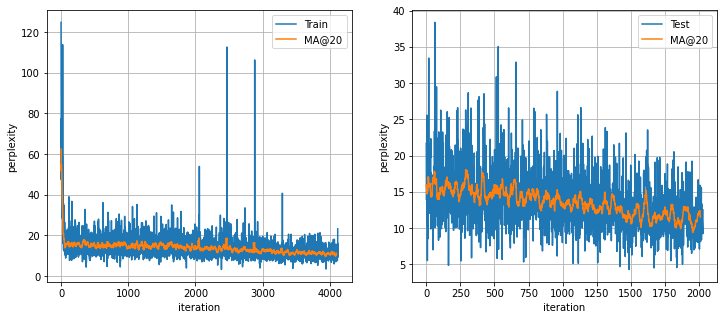

In [34]:
for epoch in range(10):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(
            tqdm(train_dataloader, total=len(train_dataloader))
    ):
        go = go.cuda()
        eos = eos.cuda()
        mask = mask.cuda()

        lstm_oracle.zero_grad()
        prediction = lstm_oracle(go, length).transpose(0, 1).transpose(1, 2)
        train_loss = (criterion(prediction, eos)*mask.float()).mean()
        train_loss.backward()
        [x.grad.clamp_(-1, 1) for x in lstm_oracle.parameters() if x.grad is not None]
        optimizer.step()
        train_losses.append(np.exp(train_loss.cpu().item()))
    
        
    for i, (go, eos, mask, length) in enumerate(
         tqdm(test_dataloader, total=len(test_dataloader))
         ):
        go = go.cuda()
        eos = eos.cuda()
        mask = mask.cuda()
        prediction = lstm_oracle(go, length).transpose(0, 1).transpose(1, 2)
        test_loss = (criterion(prediction, eos)*mask.float()).mean()
        test_losses.append(np.exp(test_loss.cpu().item()))   
        
    clear_output(True)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(moving_average(train_losses), label='MA@20')
    plt.xlabel('iteration')
    plt.ylabel('perplexity')
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(test_losses, label='Test')
    plt.plot(moving_average(test_losses), label='MA@20')
    plt.xlabel('iteration')
    plt.ylabel('perplexity')
    plt.legend()
    plt.grid()
    plt.show()

In [35]:
lstm_oracle.cpu()

LSTMOracle(
  (embedding): Embedding(33277, 32)
  (generator): LSTM(32, 64, num_layers=2)
  (classifier): Linear(in_features=64, out_features=33277, bias=True)
)

In [36]:
for _ in range(5):
  res = lstm_oracle.generate(vocab, max_len=700)
  print(res)

 even thought one frequent in sparkle all of product is my happy friends neither quit <eos>
 it glial propensities if i do passionate life is very in label all the original state where they dream to be economic <eos>
 as a good car's tours that i'm good <eos>
 i stand women i bring roller plenitude of a way without women strict the having guy that he is sure to be a began when up <eos>
 i think doesn't listening to going to do look he is a managed tide that table we change player <eos>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


#### 3. Подбор гиперпараметров

In [44]:
parameters = [ [50, 64], [50, 100], 
              [64, 128], [128, 256], 
              [200, 400]
             ]

In [45]:
best_params = None
min_loss = 1000

In [46]:
for params in parameters:
  lstm_oracle = LSTMOracle(vocab.size,
                embedding_size=32,
                hidden_size=64, layers=2)    
  
  optimizer = torch.optim.Adam(lstm_oracle.parameters(), lr=0.001, weight_decay=1e-5)
  criterion = nn.CrossEntropyLoss(reduction='none')
  losses = []
  lstm_oracle.cuda()
  for epoch in range(2):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(
            tqdm(dataloader, total=len(dataloader))
    ):
        go = go.cuda()
        eos = eos.cuda()
        mask = mask.cuda()

        lstm_oracle.zero_grad()
        prediction = lstm_oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in lstm_oracle.parameters() if x.grad is not None]
        optimizer.step()
        losses.append(np.exp(loss.cpu().item()))

  
  # print(len(losses))
  if np.asarray(losses[len(losses)-614:], dtype=np.float32).mean() < min_loss:
      min_loss = loss
      best_params = params


In [47]:
best_params

[50, 64]

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: